# Mapping - Analysis

---

### Links Used

- [Interpolating data on a grid](https://earthscience.stackexchange.com/questions/12057/how-to-interpolate-scattered-data-to-a-regular-grid-in-python)
- [Interpolating between grids with Basemap](http://earthpy.org/interpolation_between_grids_with_basemap.html)
- [EarthPy - Visualization](http://earthpy.org/category/visualization.html)
- [Counting grids from set of points using numpy](https://gis.stackexchange.com/questions/257466/creating-counting-grid-from-set-of-points-using-numpy)
- [GIS using PyData stack](http://darribas.org/gds_scipy16/gds_scipy16.pdf)
- [**GeoPlot - KDEPlot**](https://residentmario.github.io/geoplot/kdeplot.html#geoplot.kdeplot)
- [Seaborn - KDEPlot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)
- [Visualization with Python, O'Rielly Media](https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html)

### Dependencies

In [5]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata
from shapely.geometry import Point

# Plotting
from matplotlib import pyplot as plt
import geoplot as gp

### Objective

`Create a banded heatmap of yearly location activity in Iowa City.`

**Steps:**

1. Basemap class
2. Get extents of IC map
3. filter johnson county pts
4. bin points into discrete bins




- Create gridding interpolation function
    - Get extent of location points (lat/lng)
    - Divide by `n` to number of bins
    - assign points to (`i, j`) bin.
    - return grid with weights
   

In [1]:
from IC import IC
ic = IC('../data/maps/ic-water.geojson',
        '../data/maps/ic-roads.geojson',
        '../data/maps/ic-buildings.geojson')

/home/user/.miniconda3/envs/maps/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/user/.miniconda3/envs/maps/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from Coords import Coords
coords = Coords('../data/johnson-cnty-coords.csv')

coords.df.head(1)

/home/user/.miniconda3/envs/maps/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,longitude,latitude,year,value,geometry
14,-91.576424,41.65852,none,1,POINT (-91.57642390000001 41.65852020000001)


In [ ]:
fig, axes = ic.get_basemap()
coords.df.sample(10000).plot(ax=axes, marker='.', markersize=10, alpha=0.5)

#plt.gca().set_adjustable('box')
#plt.axis('equal')
plt.show()

In [ ]:
fig, axes = ic.get_basemap()
gp.kdeplot(df=coords.df[['geometry', 'count']],
           ax=axes,
           shade=True,
           shade_lowest=False,
           n_levels=7,
           gridsize=100
          )

No handles with labels found to put in legend.


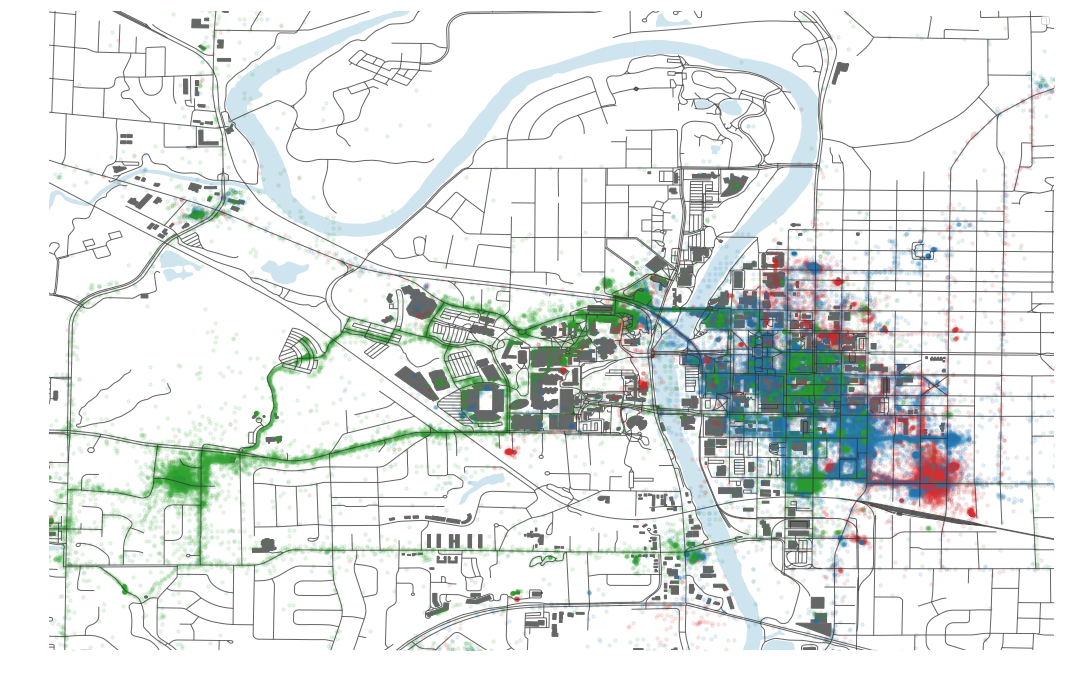

In [6]:
fig, axis = ic.get_basemap()
coords.plot_pts(axis)

plt.legend()
plt.show()

66370


/home/user/.miniconda3/envs/maps/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/user/.miniconda3/envs/maps/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/user/.miniconda3/envs/maps/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


63896


KeyboardInterrupt: 

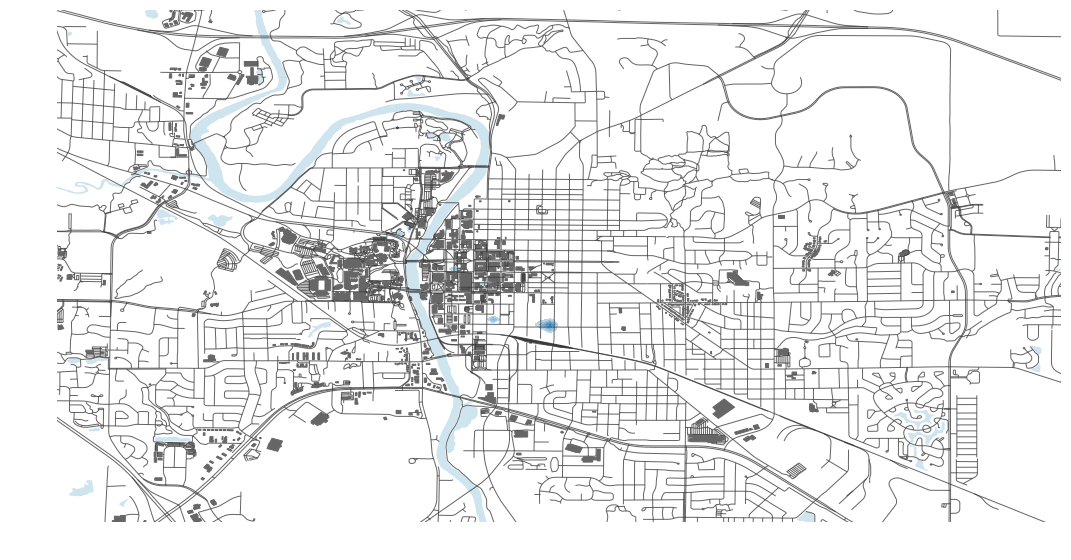

In [4]:
fig, axes = ic.get_basemap()
coords.plot_dist(axes, sample=500)

In [ ]:
coords.df.head()

### Utils

In [ ]:
# Coordinate Extents
lat_extent = [coords_df.latitude.min(),  coords_df.latitude.max()]
lng_extent = [coords_df.longitude.min(), coords_df.longitude.max()]
map_extent = (lng_extent[0], lng_extent[1], lat_extent[0], lat_extent[1])

# Coordinate Ranges
lat_range = lat_extent[1] - lat_extent[0]
lng_range = lng_extent[1] - lng_extent[0]

def create_range_step(extent, num_bins):
    return extent / num_bins

lat_step = create_range_step(lat_range, 500)
lng_step = create_range_step(lng_range, 500)

print ('Extents\n\tLat: {}, Lng: {}'.format(lat_extent, lng_extent))
print ('Ranges\n\tLat: {}, Lng: {}'.format(lat_range, lng_range))
print ('Steps\n\tLat: {}, Lng: {}'.format(lat_step, lng_step))

In [ ]:
### GRIDS

# lat is Y
# lng is X
steps_lat = np.arange(lat_extent[0], lat_extent[1], lat_step)
steps_lng = np.arange(lng_extent[0], lng_extent[1], lng_step)

grid_lat, grid_lng = np.meshgrid(steps_lat, steps_lng)

# Coord values (1, because a coordinate is *1* observation)
n = len(coords_df)
ones = np.empty(n)
ones.fill(1)

# Filled grid
#zi = griddata((x,y),z,(xi,yi),method='linear')
z = griddata((coords_df.latitude, coords_df.longitude), ones, (grid_lng, grid_lat), method='linear')

In [ ]:
def create_grid(df, numrows=240, numcols=240, method='linear'):
    # Create bins and grid
    xi = np.linspace(df.longitude.min(), df.longitude.max(), numcols)
    yi = np.linspace(df.latitude.min(), df.latitude.max(), numrows)
    xi, yi = np.meshgrid(xi, yi)
    
    # Create values
    n = len(df)
    ones = np.empty(n)
    ones.fill(1)
    
    # Interpolate data grid
    zi = griddata((df.longitude, df.latitude),
                 ones,
                 (xi, yi), method=method)
    return zi

create_grid(coords_df).max()

### Geopandas + GeoPlot

In [ ]:
test_df = gpd.GeoDataFrame(
    {
        'value': ones,
        'year': coords_df.year
    },
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(coords_df.longitude, coords_df.latitude)]
)

In [ ]:
# df1.groupby(['A','B']).size().reset_index().rename(columns={0:'count'})
unique_coords = coords.df.groupby(['longitude', 'latitude', 'year']).size().reset_index().rename(columns={0: 'count'})
unique_coords.head()

In [ ]:
unique_coords.sort_values(by=['count'], ascending=False).head()